# EDA Crypto
Este notebook contiene el análisis exploratorio de datos actualizando la codificación one-hot y con descripciones en cada sección.

## 1. Carga y limpieza inicial
En esta sección cargamos el dataset `crypto_ohlc_join.csv`, aseguramos tipos correctos y chequeamos nulos y duplicados.

In [3]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
%matplotlib inline
plt.style.use("classic")
sns.set_context("talk")

# Definir ruta y cargar
ROOT = Path.cwd().parents[1]
DATA_PATH = ROOT / "data" / "crypto_ohlc_join.csv"
assert DATA_PATH.exists(), f"No se encontró {DATA_PATH}"
df = pd.read_csv(DATA_PATH, parse_dates=["date"])

# Asegurar tipos numéricos
for col in ["close","market_cap","volume","price"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("Shape:", df.shape)
print("\nValores nulos por columna:")
print(df.isna().sum())
print("\nDuplicados totales:", df.duplicated().sum())

Shape: (55684, 10)

Valores nulos por columna:
close             0
date              0
id                0
cmc_id        21084
market_cap      366
name           1251
narrative       366
price          5276
symbol         1251
volume         5276
dtype: int64

Duplicados totales: 3


## 2. Resumen estadístico por narrativa
Observamos la distribución de `market_cap` segmentada por narrativa.

In [4]:
# Estadísticas descriptivas de market_cap
summary = df.groupby("narrative")["market_cap"].describe()
summary

,count,mean,std,min,25%,50%,75%,max
narrative,,,,,,,,
ai,12449.0,5.031318e+06,1.428922e+07,0.0,7164.590000,780167.000000,1.570640e+06,6.864756e+07
gaming,6490.0,1.000507e+07,2.102725e+07,0.0,0.000000,231757.000000,5.078962e+06,7.736332e+07
meme,33817.0,8.392966e+07,7.182393e+08,0.0,0.000000,10713.381258,7.793056e+05,6.940216e+09
rwa,2562.0,9.369945e+07,2.222203e+08,0.0,119944.212427,722627.602715,1.570122e+07,6.377669e+08


## 3. Cálculo de retornos y volatilidad
Generamos retornos a 1, 7 y 30 días, y volatilidad de 30 días para cada token.

In [5]:
# Crear features técnicos
df["ret_1d"]  = df.groupby("id")["close"].pct_change()
df["ret_7d"]  = df.groupby("id")["close"].pct_change(7)
df["ret_30d"] = df.groupby("id")["close"].pct_change(30)
df["vol_30d"] = df.groupby("id")["ret_1d"].transform(lambda x: x.rolling(30).std())

# Mostrar ejemplos
df[["id","date","close","ret_7d","ret_30d","vol_30d"]].dropna().head()

,id,date,close,ret_7d,ret_30d,vol_30d
30,NCT,2024-08-07,0.01232,-0.196871,-0.161334,0.041665
31,NCT,2024-08-08,0.01373,-0.086494,-0.120436,0.045466
32,NCT,2024-08-09,0.01371,-0.047917,-0.117193,0.045466
33,NCT,2024-08-10,0.01414,-0.002117,-0.055444,0.045451
34,NCT,2024-08-11,0.01350,-0.003690,-0.149338,0.044636


## 4. Visualización de retornos y volatilidad
Histogramas de retornos 30d y boxplot de volatilidad 30d por narrativa.

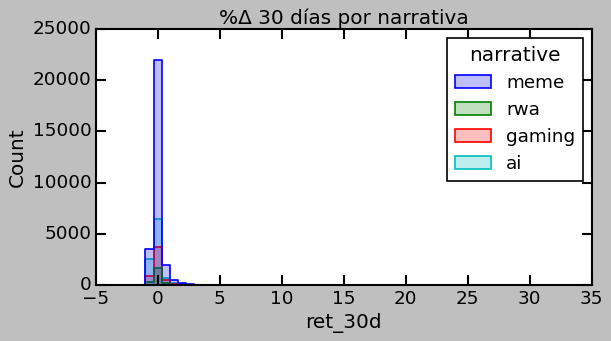

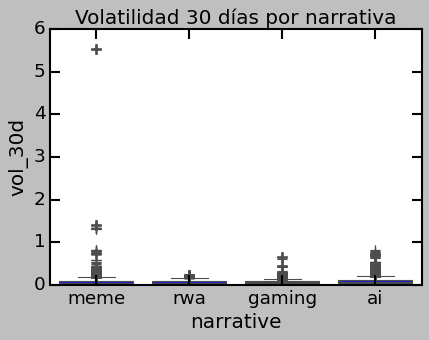

In [6]:
# Histograma de ret_30d
plt.figure(figsize=(8,4))
sns.histplot(df, x="ret_30d", hue="narrative", bins=50, element="step")
plt.title("%Δ 30 días por narrativa")
plt.show()

# Boxplot de volatilidad
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="narrative", y="vol_30d")
plt.title("Volatilidad 30 días por narrativa")
plt.show()

## 5. Heatmap de correlación 90d
Para los 30 tokens de mayor `market_cap`, calculamos la correlación de retornos en los últimos 90 días.

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8172\1692092311.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  corr = p90.pct_change().corr().fillna(0)


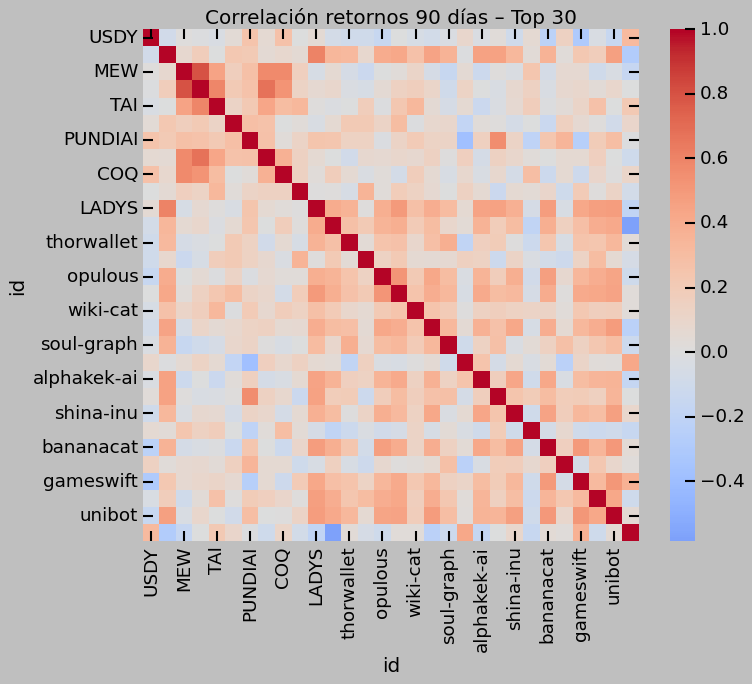

In [7]:
cut = df["date"].max() - pd.Timedelta(days=90)
sub90 = df[df["date"] >= cut].sort_values("date").drop_duplicates(["date","id"], keep="last")
p90 = sub90.pivot(index="date", columns="id", values="close")
corr = p90.pct_change().corr().fillna(0)
top30 = df.groupby("id")["market_cap"].last().nlargest(30).index

plt.figure(figsize=(10,8))
sns.heatmap(corr.loc[top30, top30], cmap="coolwarm", center=0)
plt.title("Correlación retornos 90 días – Top 30")
plt.show()

## 6. Filtrado por histórico mínimo
Mantener solo tokens con ≥60 días de datos para garantizar cálculos de volatilidad.

In [8]:
# Filtrado de tokens con suficiente histórico
lengths = df.groupby("id")["date"].nunique().reset_index(name="n_days")
good_ids = lengths[lengths["n_days"] >= 60]["id"]
df_filt = df[df["id"].isin(good_ids)].copy()
print("Tokens retainidos:", len(good_ids))

# Recalcular features sobre df_filt
features = df_filt.copy()
features["ret_1d"] = features.groupby("id")["close"].pct_change()
features["ret_7d"] = features.groupby("id")["close"].pct_change(7)
features["ret_30d"] = features.groupby("id")["close"].pct_change(30)
features["sma_7"] = features.groupby("id")["close"].transform(lambda x: x.rolling(7).mean())
features["sma_30"] = features.groupby("id")["close"].transform(lambda x: x.rolling(30).mean())
features["bb_width"] = features.groupby("id")["close"].transform(lambda x: x.rolling(20).std()) / features["close"]
features["vol_30d"] = features.groupby("id")["ret_1d"].transform(lambda x: x.rolling(30).std())
features["future_ret_30d"] = features.groupby("id")["close"].pct_change(-30)

train_df = features.dropna(subset=["ret_7d","ret_30d","sma_7","sma_30","bb_width","vol_30d","future_ret_30d"])                    .sort_values("date").groupby("id").tail(1)
print("Filas útiles para ML:", len(train_df))

Tokens retainidos: 129
Filas útiles para ML: 123


## 7. Clustering K-Means
Segmentamos tokens en 4 clusters según perfil momentum/volatilidad/tendencia.

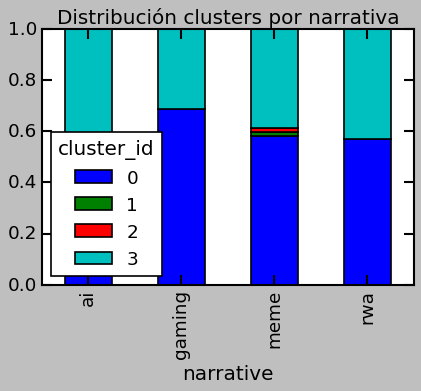

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

feats = ["ret_7d","ret_30d","vol_30d","sma_7","sma_30","bb_width"]
Xnum = train_df[feats].replace([np.inf,-np.inf], np.nan).dropna()
if not Xnum.empty:
    Xs = StandardScaler().fit_transform(Xnum)
    km = KMeans(n_clusters=4, random_state=42).fit(Xs)
    train_df.loc[Xnum.index, "cluster_id"] = km.labels_.astype(str)
    # Visualizar
    ct = train_df.groupby(["narrative","cluster_id"]).size().unstack(fill_value=0)
    ct.div(ct.sum(axis=1), axis=0).plot.bar(stacked=True, figsize=(6,4))
    plt.title("Distribución clusters por narrativa")
    plt.show()
else:
    print("No hay filas válidas para clustering.")

## 8. Preparación final del dataset para ML
Codificamos variables categóricas y dividimos en train/val.

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Selección de columnas
keep = ["narrative","market_cap","volume","ret_7d","ret_30d","sma_7","sma_30","bb_width","vol_30d","cluster_id","future_ret_30d"]
keep = [c for c in keep if c in train_df.columns]
ml_df = train_df[keep].dropna()

# One-hot encoding con sklearn>=1.4
enc = OneHotEncoder(sparse_output=False, drop="first")
cat = enc.fit_transform(ml_df[["narrative","cluster_id"]])
cat_cols = enc.get_feature_names_out(["narrative","cluster_id"])

# Construir X e y
X_num = ml_df.drop(columns=["narrative","cluster_id","future_ret_30d"])
X = pd.concat([X_num.reset_index(drop=True), pd.DataFrame(cat, columns=cat_cols)], axis=1)
y = ml_df["future_ret_30d"]

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train:", X_train.shape, "X_val:", X_val.shape)

X_train: (85, 14) X_val: (22, 14)


## 9. Exportar dataset para entrenamiento
Guardamos el `ml_df` final en un CSV en la carpeta `data` para usar en el notebook de modelado.

In [11]:
# Definir ruta de salida
from pathlib import Path
ROOT = Path.cwd().parents[1]
OUT_PATH = ROOT / "data" / "ml_dataset.csv"

# Guardar
ml_df.to_csv(OUT_PATH, index=False)
print(f"✅ Dataset ML guardado en: {OUT_PATH}")

✅ Dataset ML guardado en: c:\UPC\2025-1\MachineLearning\TrabajoFinal\MachineLearning_TF\data\ml_dataset.csv


### 🔍 Análisis exploratorio avanzado – perfilado y clusters de correlación  

* Generamos un **informe automático** (ydata-profiling) para detectar
  distribuciones, outliers y relaciones ocultas.  
* Calculamos la **matriz de correlación** solo para los retornos
  (Δ%) de los últimos 90 días y aplicamos *hierarchical clustering*
  para revelar “mini-sectores” dentro de cada narrativa.  
* El archivo html se guarda en `reports/profile_crypto.html`.  
  (Puedes abrirlo en el explorador para un vistazo rápido.)


In [17]:
# %% [code] ─────────── Sweetviz report (robusto) ───────────
import os, warnings, pathlib, numpy as np, pandas as pd, sweetviz as sv

# 1️⃣  Parche para NumPy ≥2.2
if not hasattr(np, "VisibleDeprecationWarning"):
    class _VDW(UserWarning): pass
    np.VisibleDeprecationWarning = _VDW

# 2️⃣  Carga de datos (sin parse_dates)
DATA_PATH = pathlib.Path("../../data/ml_dataset.csv")   # ajusta si es otra ruta
df = pd.read_csv(DATA_PATH)

# Si la columna 'date' existe → convértela
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

display(df.head())

# 3️⃣  Informe Sweetviz (máx 5 000 filas para tamaño razonable)
sample_df = df.sample(min(5_000, len(df)), random_state=42)
report = sv.analyze(sample_df)

# 4️⃣  Guardar
out_html = pathlib.Path("../../reports/sweetviz_crypto.html")
out_html.parent.mkdir(parents=True, exist_ok=True)
report.show_html(str(out_html), open_browser=False)

print(f"✅ Informe guardado en ➜ {out_html.resolve()}")


,narrative,market_cap,volume,ret_7d,ret_30d,sma_7,sma_30,bb_width,vol_30d,cluster_id,future_ret_30d
0,ai,6390.70,1.14,0.143164,0.318811,0.000007,0.000006,0.052517,0.064950,0,0.220198
1,ai,12580.77,4.97,-0.179978,0.154281,0.000031,0.000029,0.095881,0.063185,0,0.609897
2,ai,23651.00,6.53,-0.060415,0.247716,0.000026,0.000021,0.182911,0.086268,0,0.051540
3,ai,1443249.00,6.16,0.417425,0.701156,0.043002,0.035270,0.109074,0.079329,0,-0.445229
4,meme,107137.00,107.15,-0.154055,-0.388971,0.000021,0.000028,0.267150,0.099369,3,0.711866


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report ..\..\reports\sweetviz_crypto.html was generated.
✅ Informe guardado en ➜ C:\UPC\2025-1\MachineLearning\TrabajoFinal\MachineLearning_TF\reports\sweetviz_crypto.html
